In [206]:
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt


def read_dcm_images(img_path: str) -> np.array:
    dcm_file = pydicom.read_file(img_path)
    return dcm_file.pixel_array


def plot_img(img, title="Image", cmap="gray"):
    """Plots an image using OpenCV and Matplotlib.

    Args:
        img: OpenCV image (grayscale or color).
        title: Optional title for the plot.
        cmap: Optional colormap for grayscale images.
    """

    # Convert BGR to RGB if necessary
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Create the plot using Matplotlib
    plt.figure(figsize=(8, 6))  # Set a default figure size
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")  # Remove axis labels
    plt.show()


def find_roi_bbox_around_centers(contours, img_shape, sort_roi=False):
    # Get the center of the image
    center_x, center_y = img_shape[1] // 2, img_shape[0] // 2
    approx_start_x, approx_start_y = 0.4 * center_x, 0.50 * center_y

    # Initialize variables for top-left and bottom-right corners around the center
    centered_top_left_min = (int(center_x - approx_start_x), int(center_y - approx_start_y)) # x, y
    centered_bottom_right_max = (int(center_x + approx_start_x), int(center_y + approx_start_y))
    constrain_top_left_min = centered_top_left_min
    constrain_bottom_right_max = centered_bottom_right_max
    if sort_roi:
        sorted(contours, key=cv2.contourArea, reverse=True)

    # Loop through each contour and update the top-left and bottom-right corners around the center
    for contour in contours:
        # Get the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Check if the contour is around the center of the image
        if centered_top_left_min[0] < x < centered_bottom_right_max[0] \
            and centered_top_left_min[1] < y < centered_bottom_right_max[1]:
            # Update the top-left corner around the center
            centered_top_left_min = (min(centered_top_left_min[0], x), min(centered_top_left_min[1], y))
            if x + h < constrain_bottom_right_max[0] and y + h < centered_bottom_right_max[1]:
                # Update the bottom-right corner around the center
                centered_bottom_right_max = (max(centered_bottom_right_max[0], x + w), max(centered_bottom_right_max[1], y + h))
    return centered_top_left_min[0], centered_top_left_min[1], centered_bottom_right_max[0], centered_bottom_right_max[1]


def is_contour_inside_roi(contour, roi_area) -> bool:
    # Your contour and bounding box
    bbox = cv2.boundingRect(contour)
    # Extract the coordinates of the bounding box
    x, y, width, height = bbox

    x1_roi, y1_roi, x2_roi, y2_roi = roi_area

    # Check if the bounding box is completely inside the specified bounding box
    is_inside = (x1_roi<= x <= x2_roi and
                y1_roi <= y <= y2_roi and
                x1_roi+ width <= x2_roi and
                y1_roi + height <= y2_roi)
    return is_inside

In [209]:
def find_otsu_thresholding(image, is_normalized=False, bins_num=256):
    # Get the image histogram
    hist, bin_edges = np.histogram(image, bins=bins_num)
    # print(bin_edges)
    # print(hist)
    
    # Get normalized histogram if it is required
    if is_normalized:
        hist = np.divide(hist.ravel(), hist.max())
    
    # Calculate centers of bins
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.
    
    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    
    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]
    
    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    
    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)
    
    threshold = bin_mids[:-1][index_of_max_val]
    return threshold


def image_segmentation_using_otsu_threshold(image, offset=80):
    if len(image.shape) > 2:
        # Convert the image to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # otsu thresholding
    otsu_threshold = find_otsu_thresholding(image)
    if otsu_threshold < 45:
        otsu_threshold += offset
    elif otsu_threshold >= 45 and otsu_threshold < 100:
        otsu_threshold += 50
    
    print(otsu_threshold)
    
    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(image, otsu_threshold, 255, cv2.THRESH_BINARY)
    # print(otsu_threshold)
    # segmented_image = cv2.bitwise_and(segmented_image, segmented_image, mask)
    return segmented_image

In [210]:
def predict_tumor_segmentation(image, **kwargs):
    segmented_image = image_segmentation_using_otsu_threshold(image, **kwargs)
    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    sorted(contours, key=cv2.contourArea, reverse=True)
    roi_area = find_roi_bbox_around_centers(contours, image.shape, sort_roi=False)
    print(roi_area)

    contours_inside_roi = []
    contours_inside_roi_mask = np.zeros_like(segmented_image)
    is_tumor_detected = False

    for contour in contours:
        if is_contour_inside_roi(contour, roi_area):
            contours_inside_roi.append(contour)
            cv2.drawContours(contours_inside_roi_mask, [contour], 0, 255, thickness=cv2.FILLED)
            if not is_tumor_detected:
                is_tumor_detected = True

    # Apply the filled mask to the original image
    result_image = np.copy(image)  # Make a copy of the original image

    # You can also draw a rectangle around all contours if needed
    cv2.rectangle(result_image, (roi_area[0], roi_area[1]), (roi_area[2], roi_area[3]), (0, 255, 0), 1)
    result_image[contours_inside_roi_mask == 255] = (255, 0, 0)  # Set the filled region to a specific color (e.g., red)
    return is_tumor_detected, contours_inside_roi, contours_inside_roi_mask, result_image


def calculate_roi_size(segmented_image):
    # Assuming segmented_image is your segmented image
    height, width = segmented_image.shape[:2]

    # Create a binary mask for pixels with value 255
    mask_255 = (segmented_image == 255).astype(np.uint8)

    # Calculate the total area with pixel value 255
    total_area_255 = np.sum(mask_255)
    return total_area_255

In [211]:
def plot_histogram(image, image_name):
    # Calculate the histogram
    hist, bins = np.histogram(image.flatten(), bins=256, range=[0,256])

    # Plot the histogram
    plt.plot(hist, color='black')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title(image_name)
    plt.show()

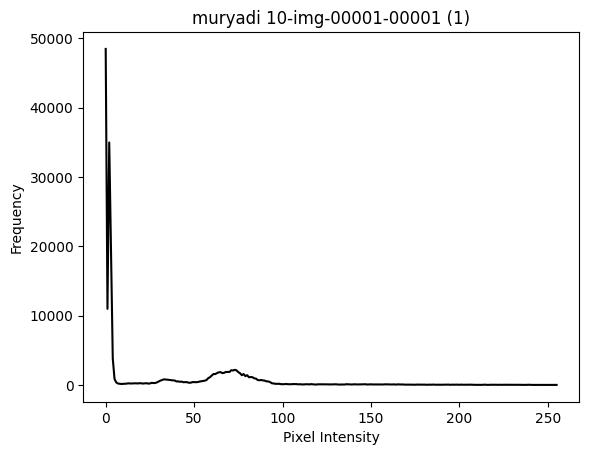

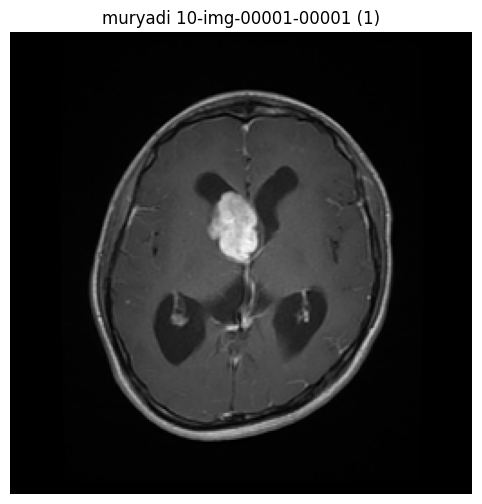

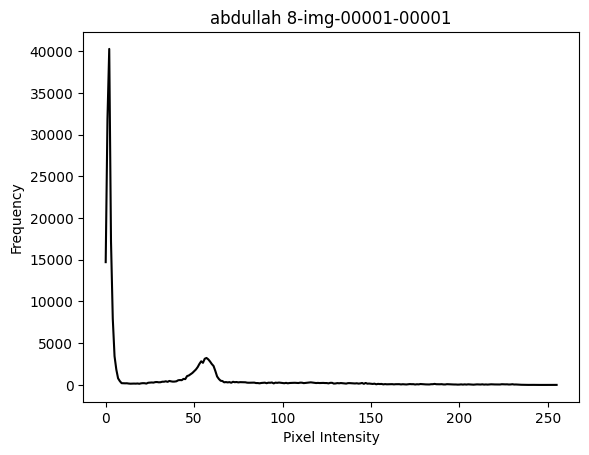

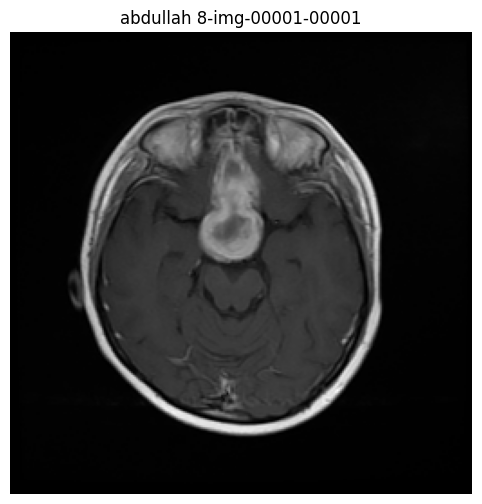

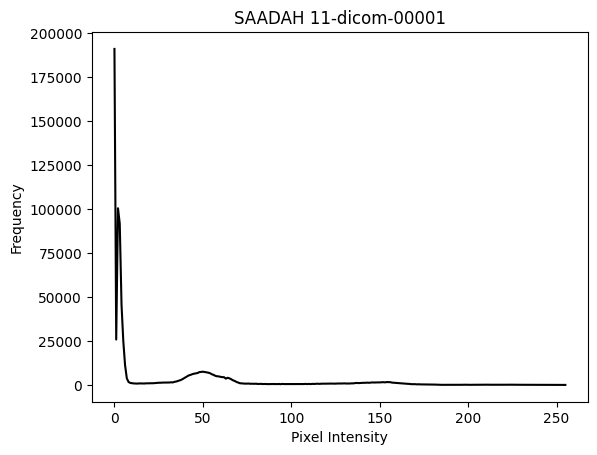

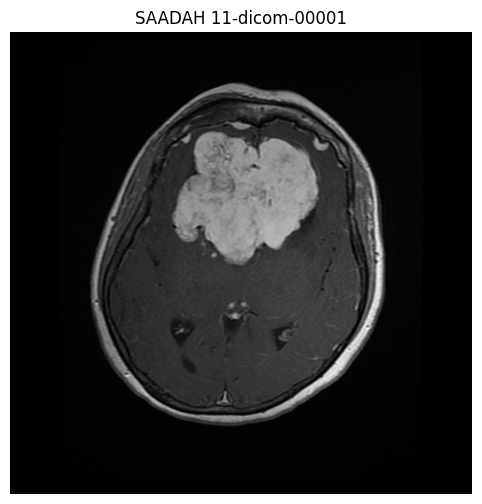

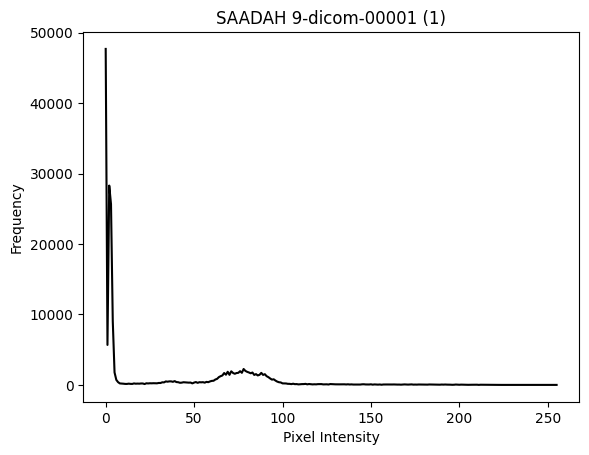

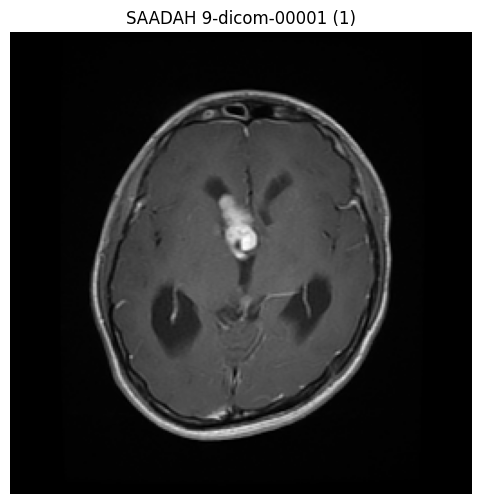

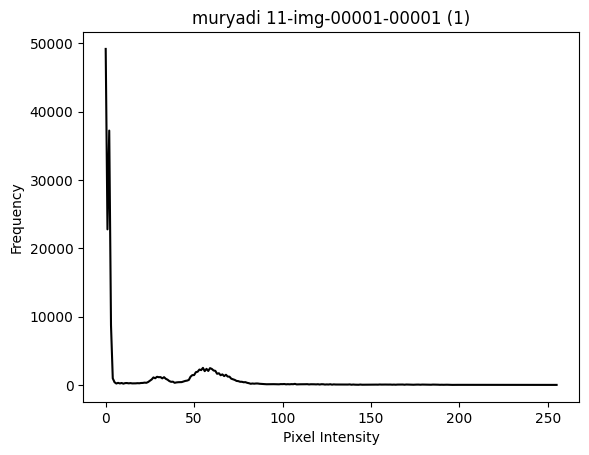

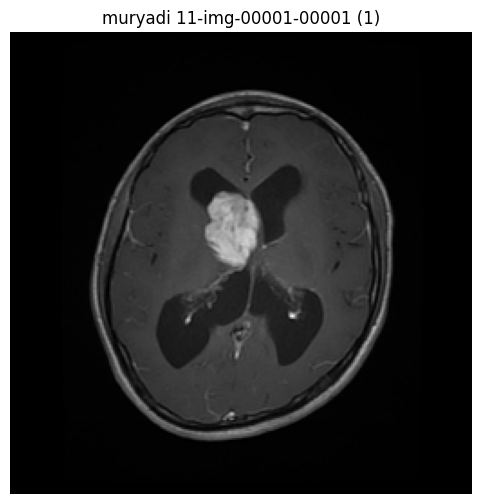

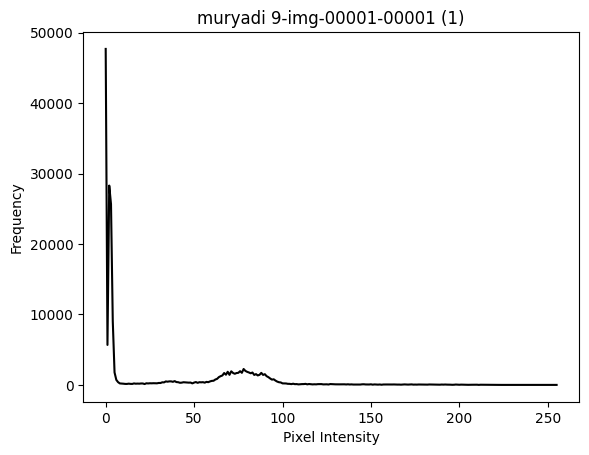

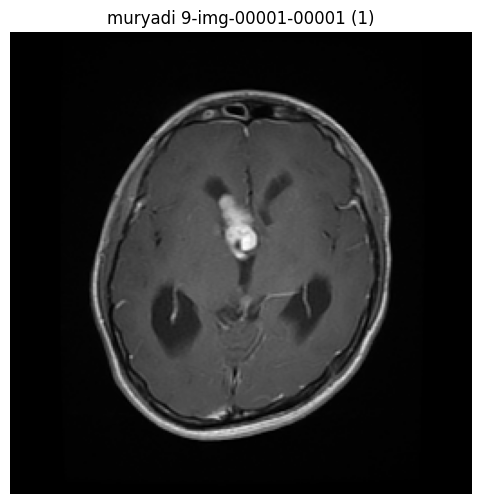

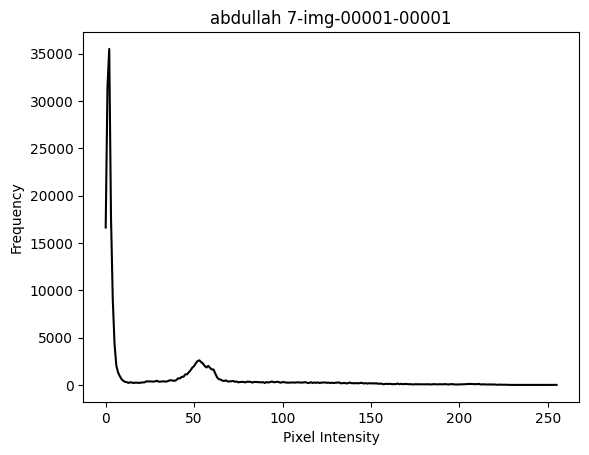

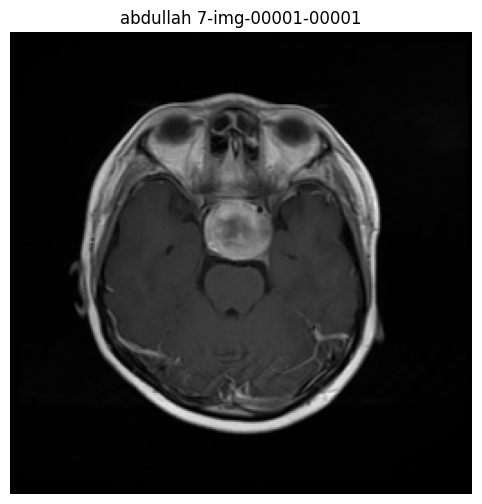

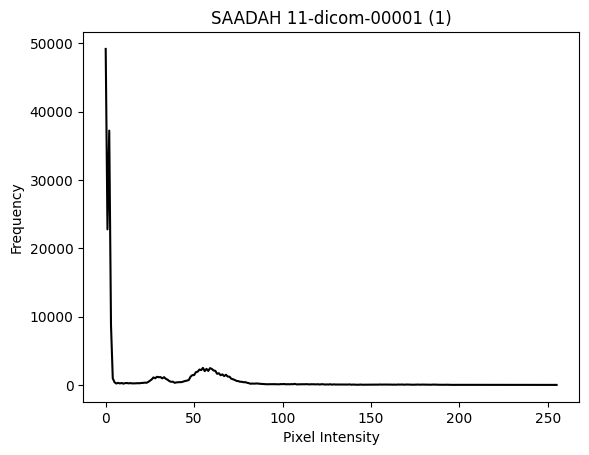

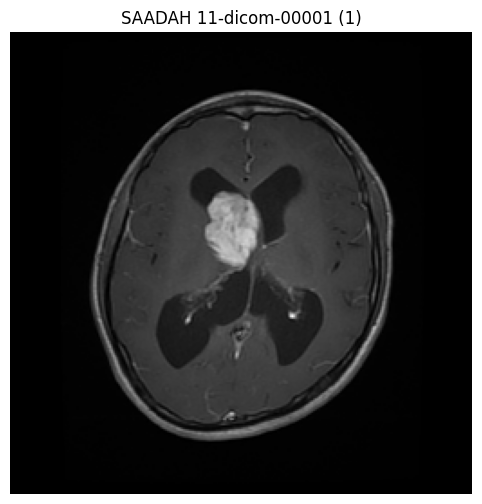

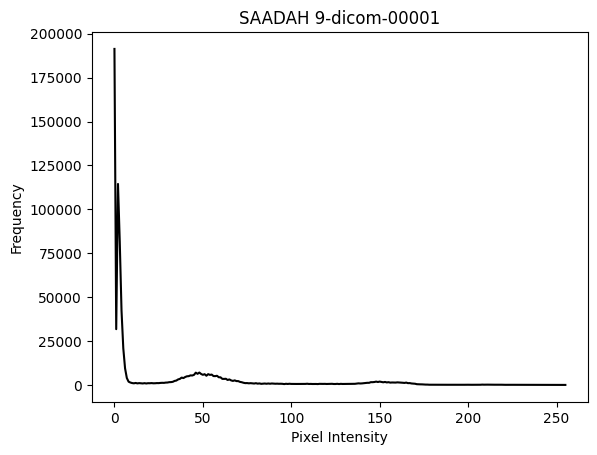

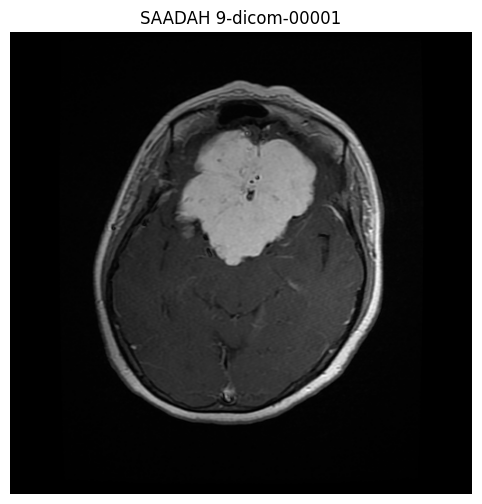

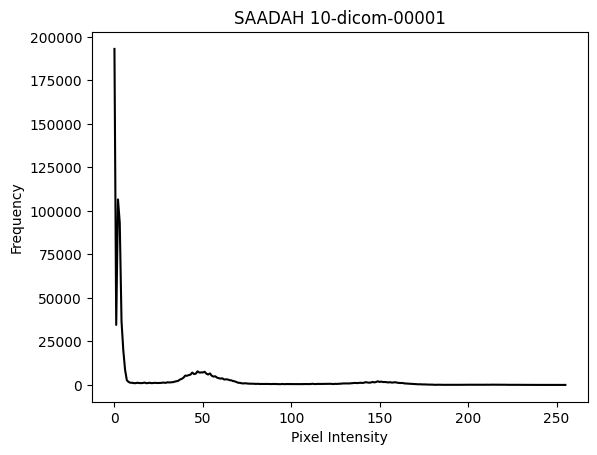

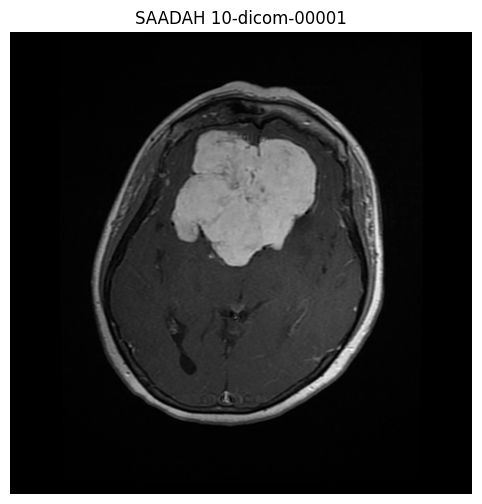

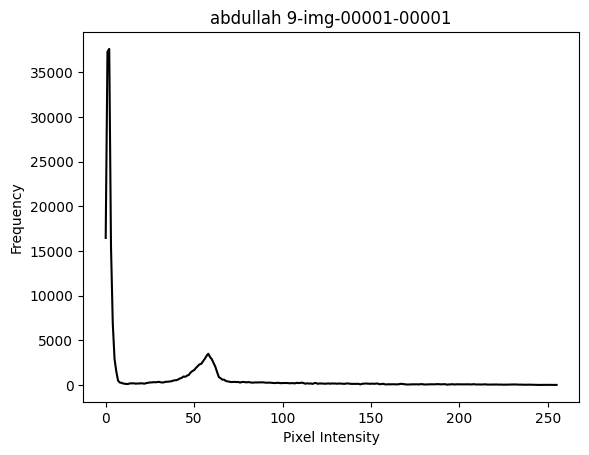

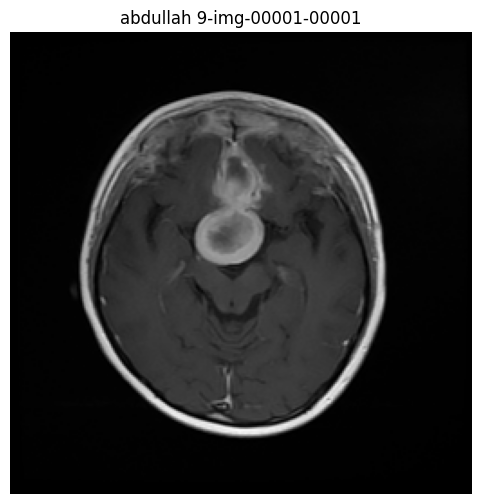

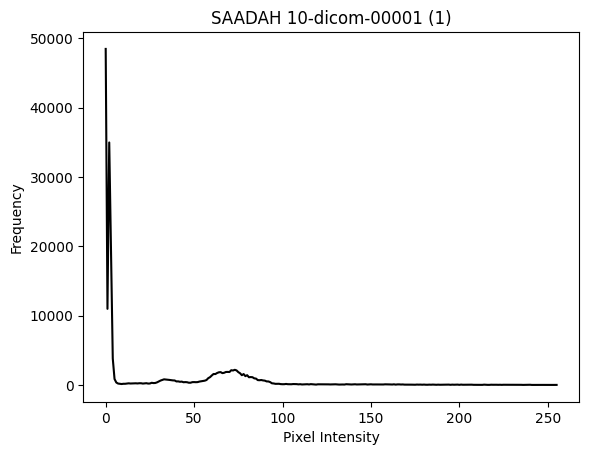

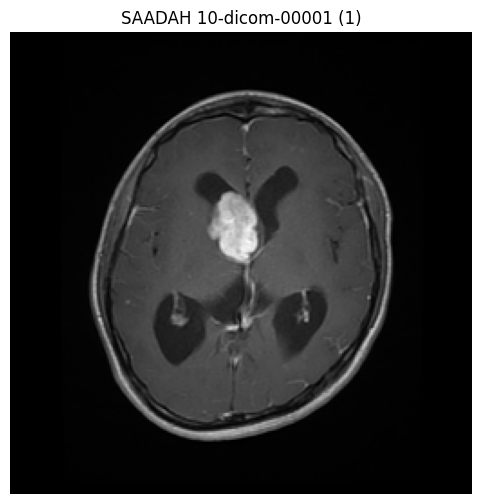

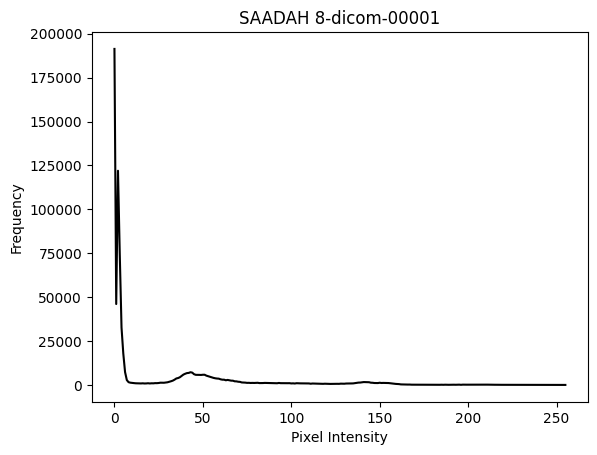

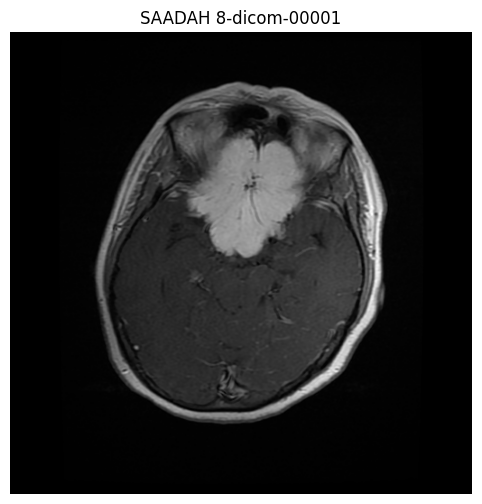

In [212]:
import glob
import os
    # print(bin_edges)
    # print(hist)
DATASET_DIR = "sample_input/"
list_read_img = []
list_img_names = []

for img_path in glob.glob(os.path.join(DATASET_DIR,"*")):
    img_ext = img_path.split(".")[-1]
    img_name = os.path.split(img_path)[-1].split(".")[0]
    list_img_names.append(f"{img_name}.{img_ext}")
    # print(img_name)
    img = None
    if img_ext == "dcm":
        img = read_dcm_images(img_path)
    else:
        img = cv2.imread(img_path)
    list_read_img.append(img)
    plot_histogram(img, img_name)
    plot_img(img, title=img_name)

muryadi 10-img-00001-00001 (1).bmp
121.337890625
(76, 64, 179, 192)


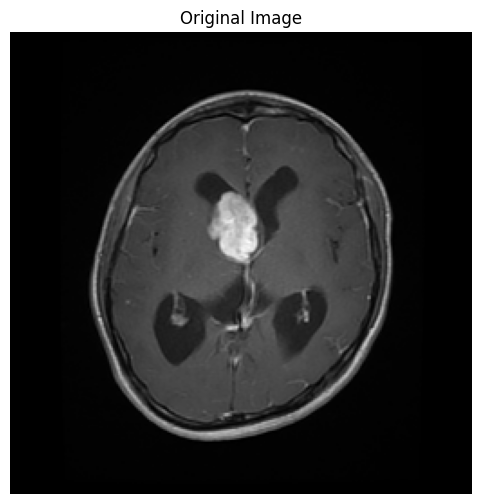

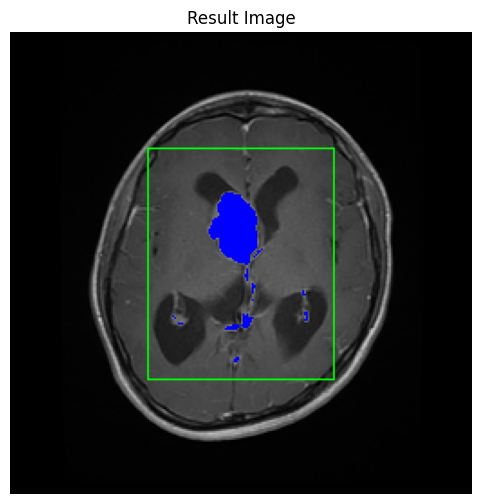

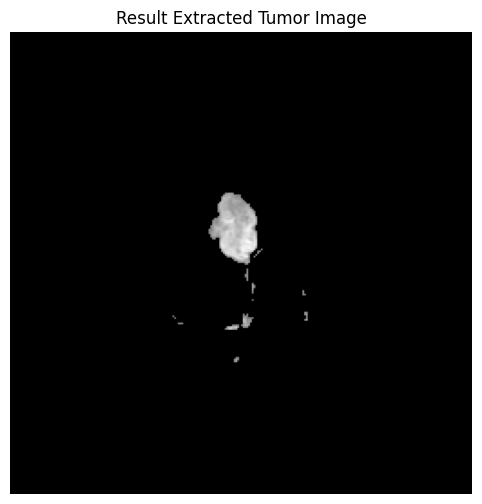

abdullah 8-img-00001-00001.bmp
122.333984375
(76, 64, 179, 192)


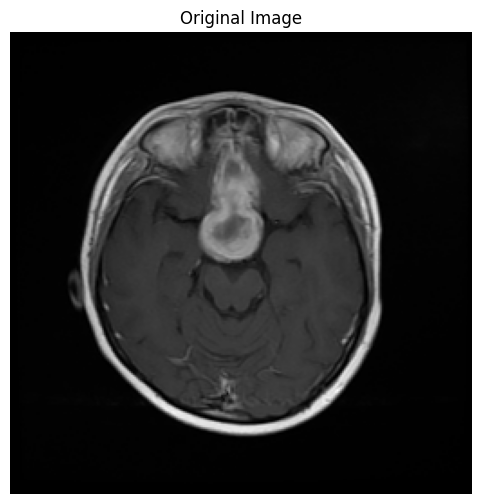

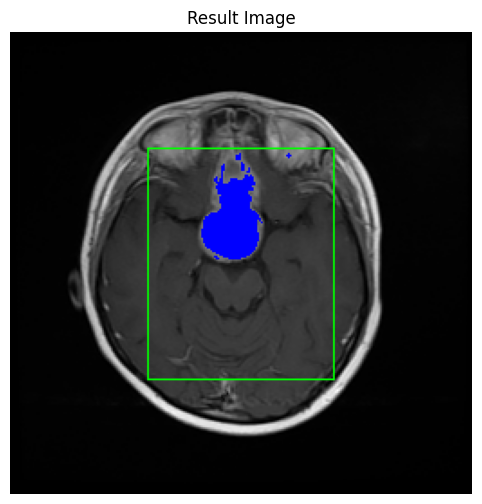

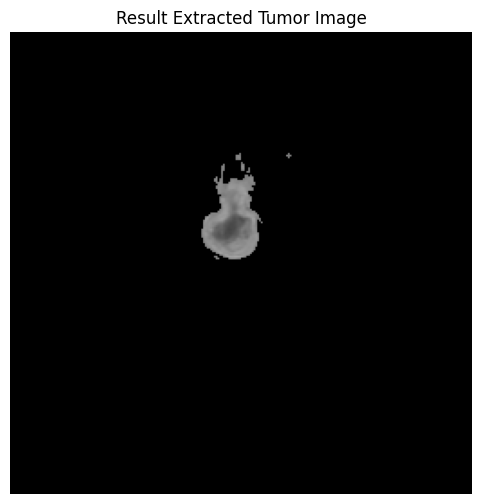

SAADAH 11-dicom-00001.dcm
126.201171875
(153, 128, 358, 384)


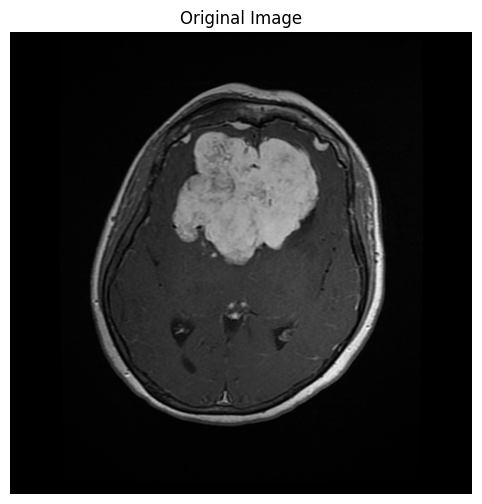

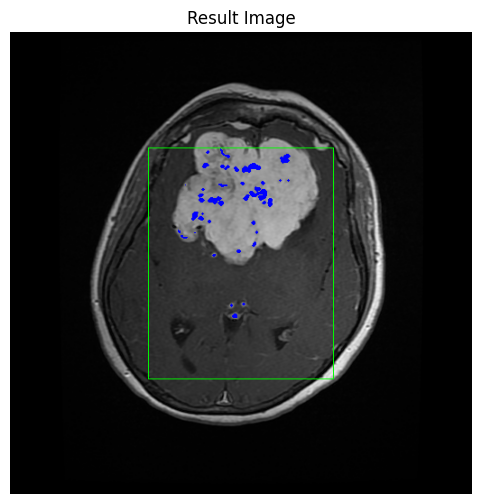

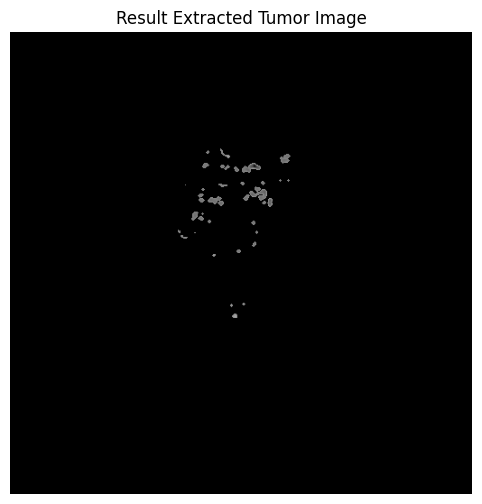

SAADAH 9-dicom-00001 (1).dcm
123.330078125
(76, 64, 179, 192)


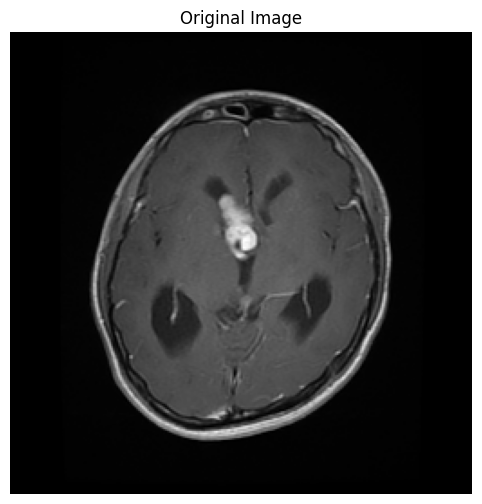

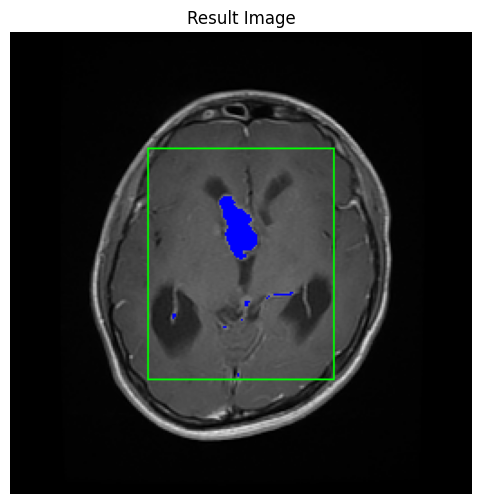

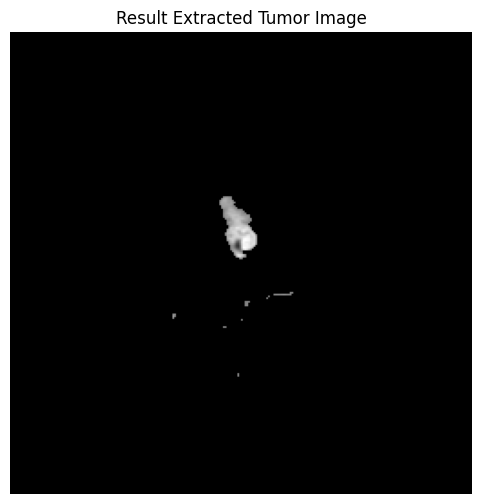

muryadi 11-img-00001-00001 (1).bmp
115.361328125
(76, 64, 179, 192)


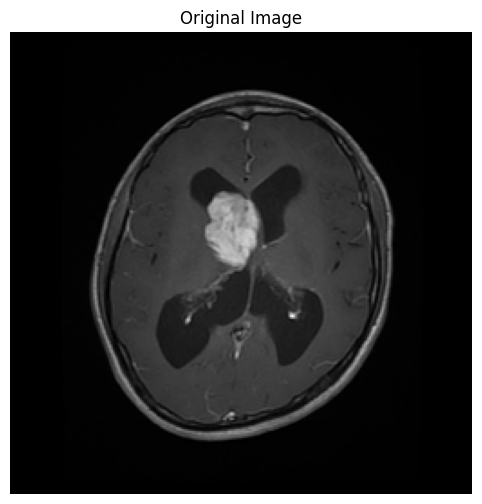

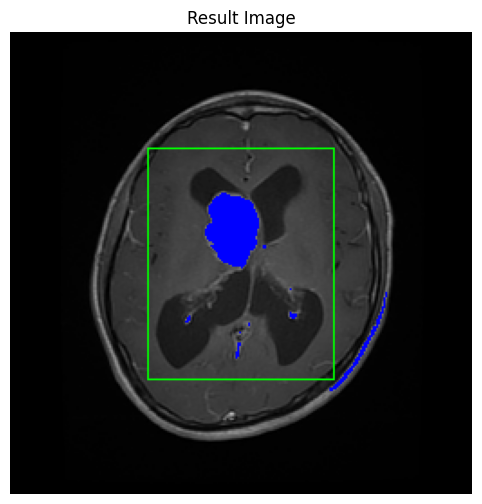

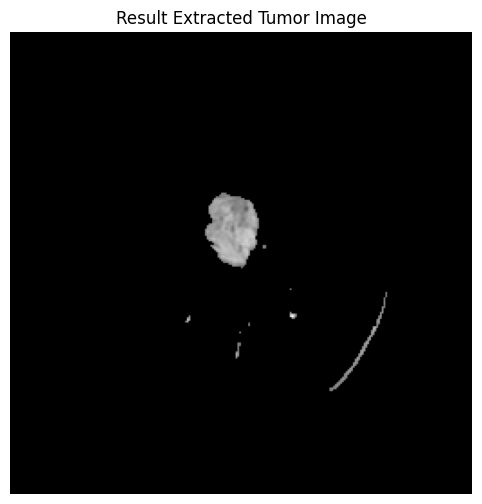

muryadi 9-img-00001-00001 (1).bmp
123.330078125
(76, 64, 179, 192)


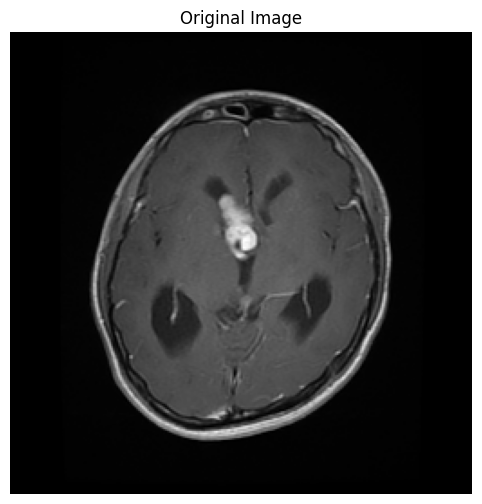

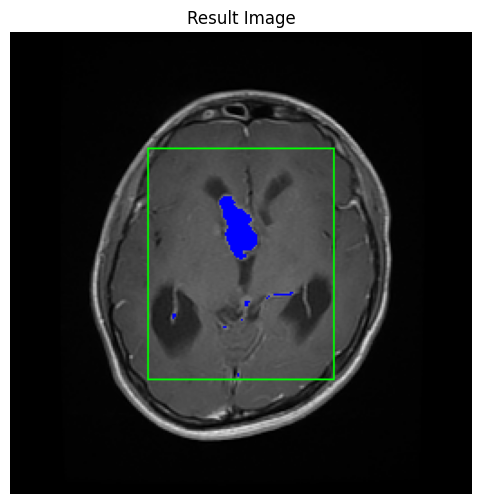

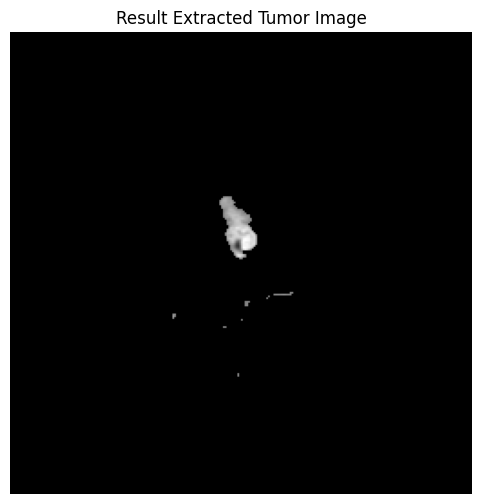

abdullah 7-img-00001-00001.bmp
123.330078125
(76, 64, 179, 192)


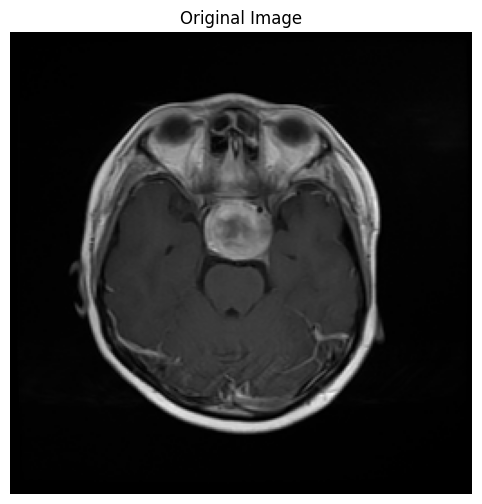

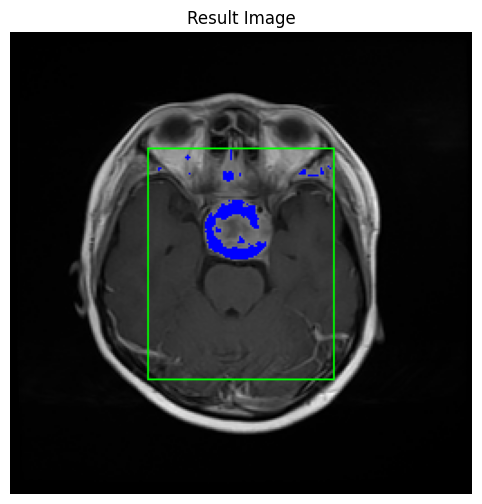

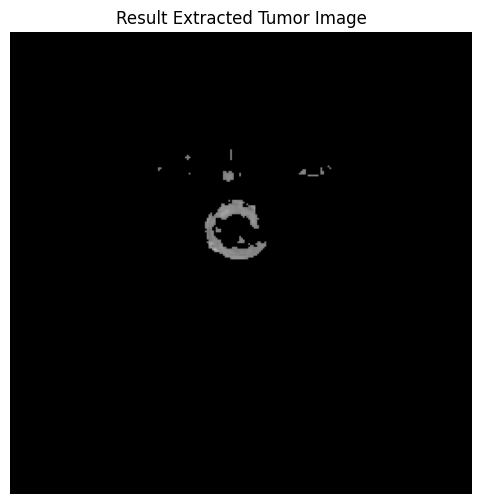

SAADAH 11-dicom-00001 (1).dcm
115.361328125
(76, 64, 179, 192)


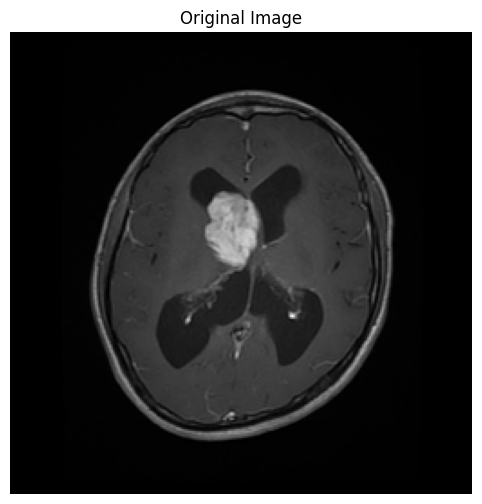

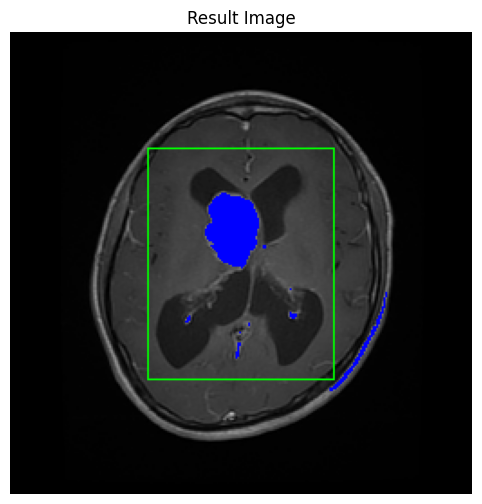

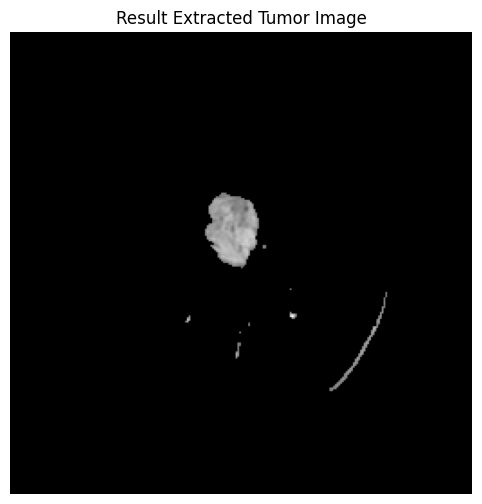

SAADAH 9-dicom-00001.dcm
125.205078125
(153, 128, 358, 384)


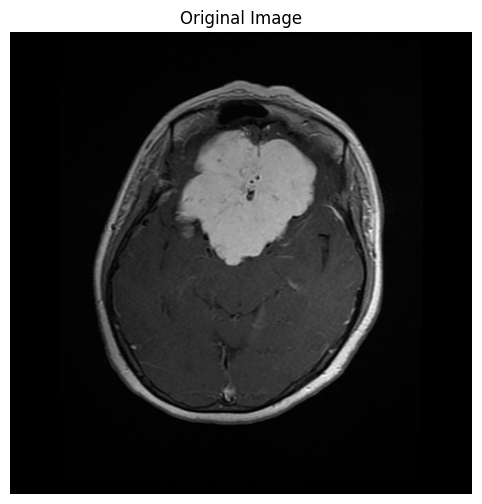

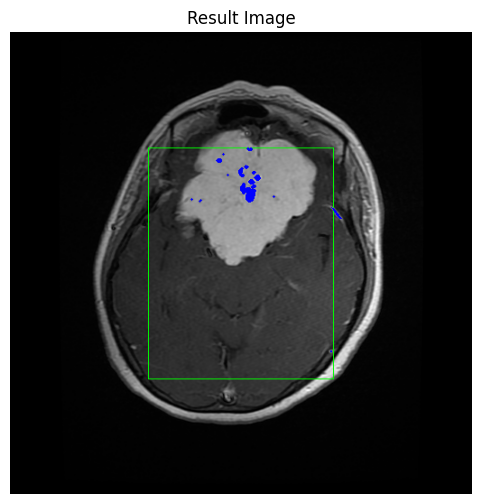

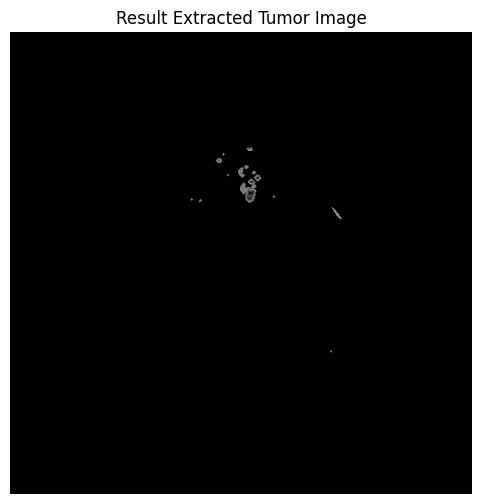

SAADAH 10-dicom-00001.dcm
126.201171875
(153, 128, 358, 384)


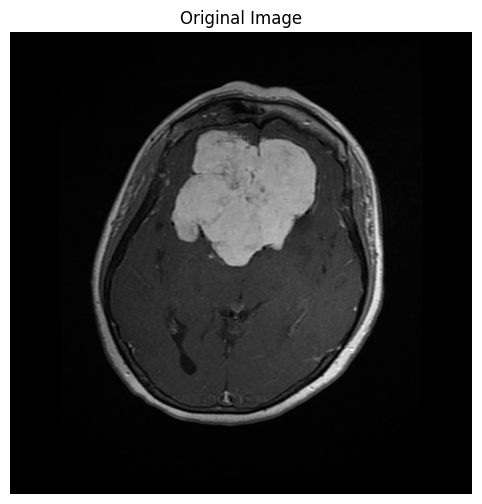

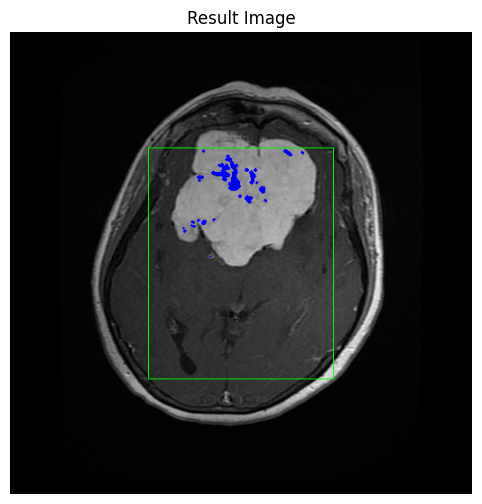

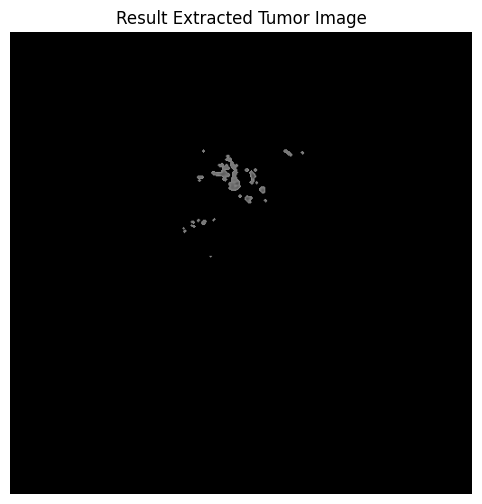

abdullah 9-img-00001-00001.bmp
120.341796875
(76, 64, 179, 192)


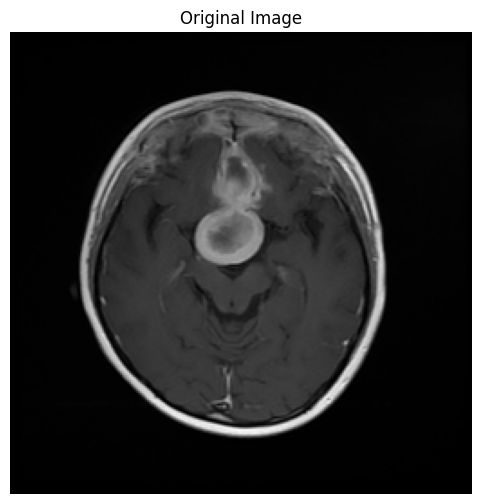

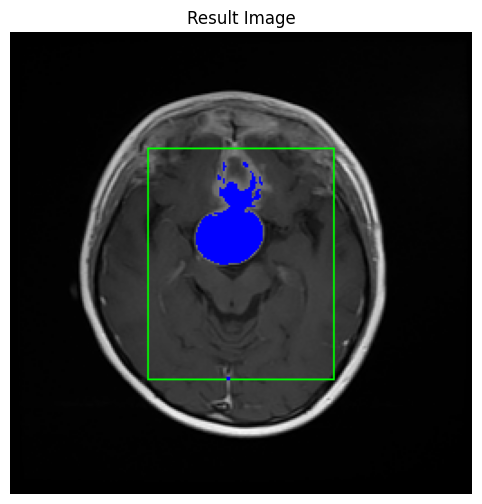

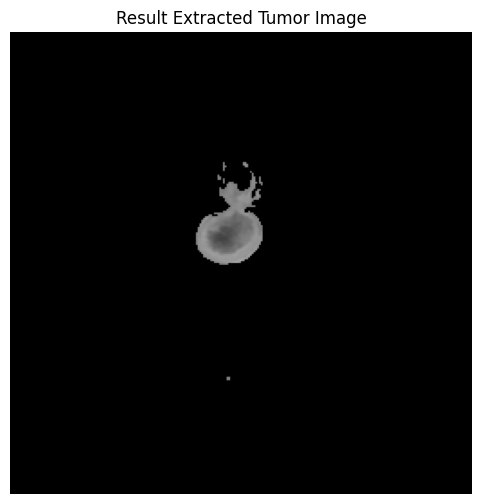

SAADAH 10-dicom-00001 (1).dcm
121.337890625
(76, 64, 179, 192)


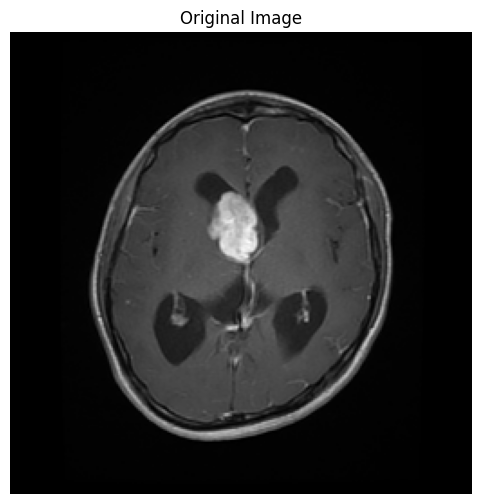

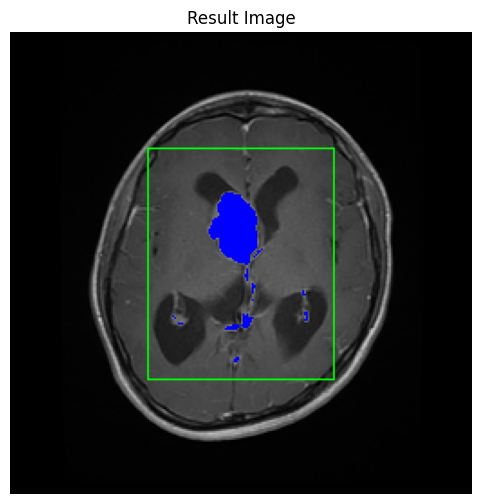

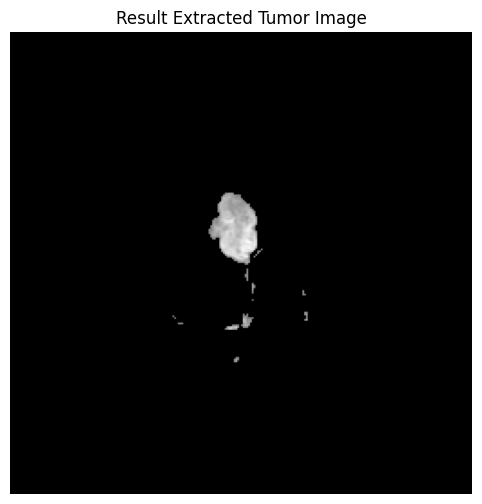

SAADAH 8-dicom-00001.dcm
112.255859375
(153, 128, 358, 384)


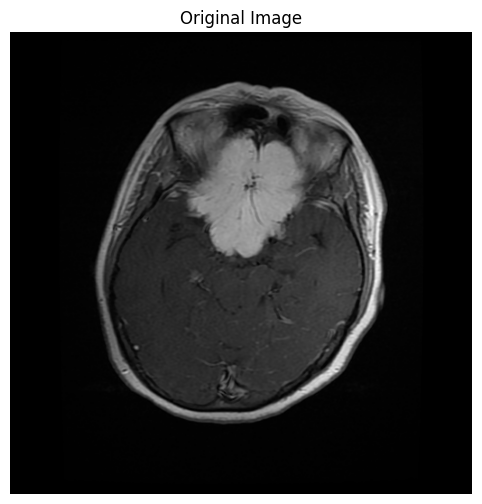

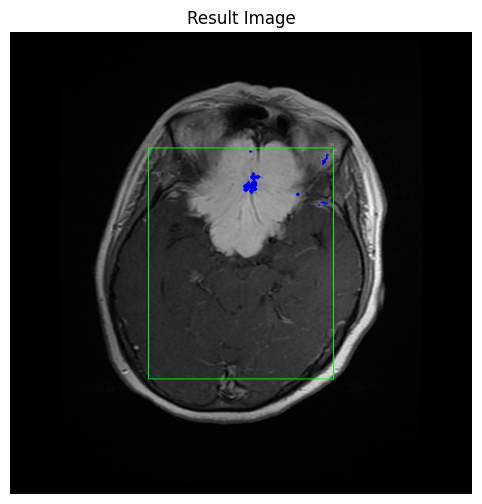

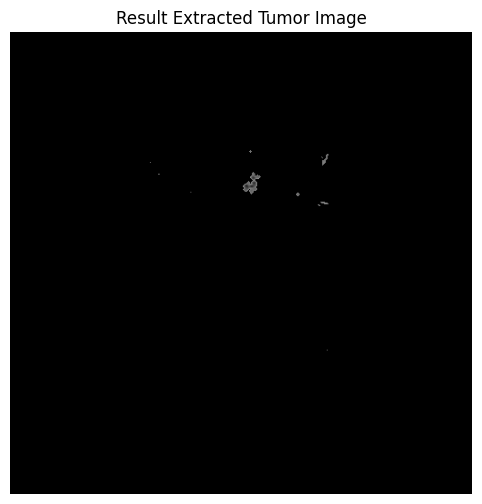

In [213]:
result_tumor_prediction = []
result_tumor_size = []
kwargs = {
    "offset": 80
}
for img_name, img in zip(list_img_names, list_read_img):
    print(img_name)
    is_tumor_detected, _, contours_inside_roi_mask, result_image = predict_tumor_segmentation(img, **kwargs)
    is_tumor_detected = 1 if is_tumor_detected else 0
    result_tumor_prediction.append(is_tumor_detected)
    #Extract the tumor image from the original image
    extracted_tumor_img = cv2.bitwise_and(img, img, mask=contours_inside_roi_mask)
    result_tumor_size.append(calculate_roi_size(contours_inside_roi_mask))
    plot_img(img, title=f"Original Image")
    plot_img(result_image, title=f"Result Image")
    plot_img(extracted_tumor_img, title="Result Extracted Tumor Image")

muryadi 10-img-00001-00001 (1).bmp
41.337890625


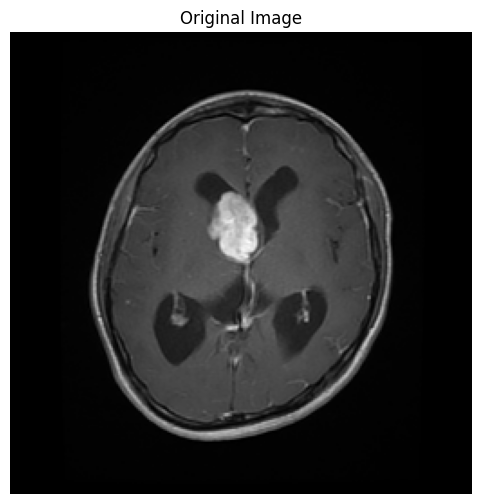

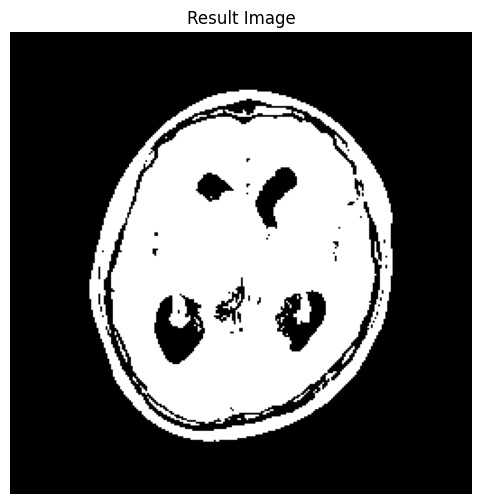

abdullah 8-img-00001-00001.bmp
42.333984375


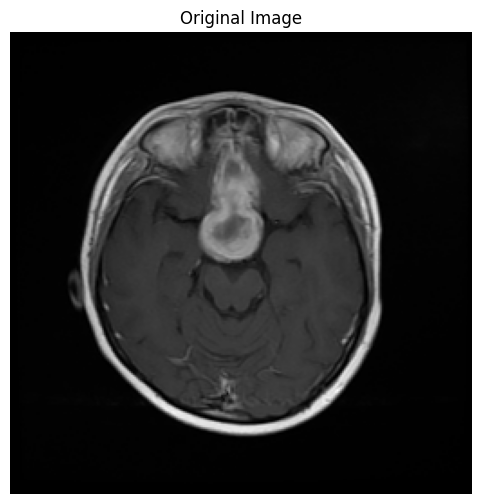

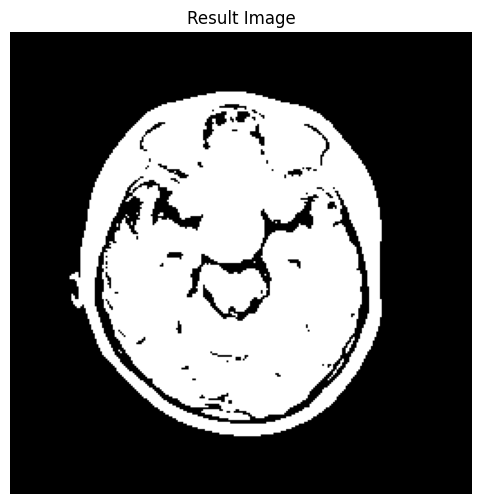

SAADAH 11-dicom-00001.dcm
126.201171875


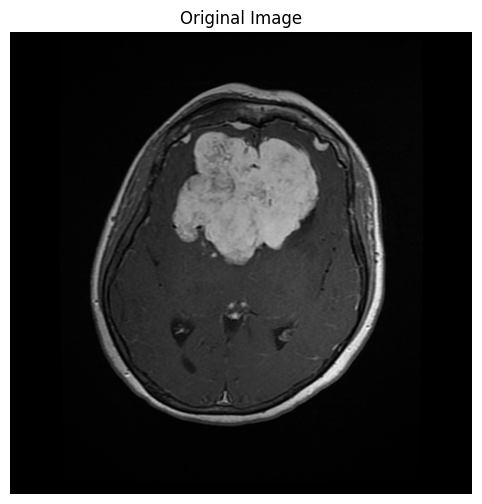

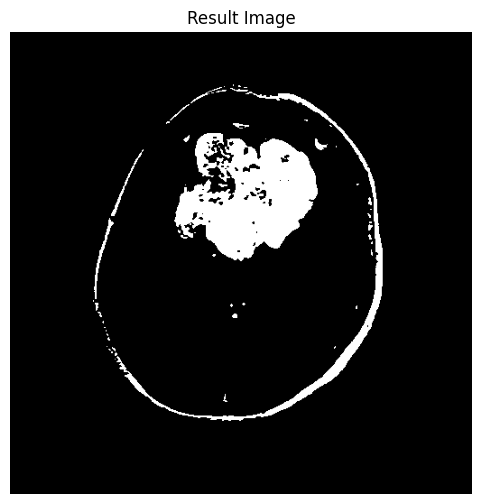

SAADAH 9-dicom-00001 (1).dcm
43.330078125


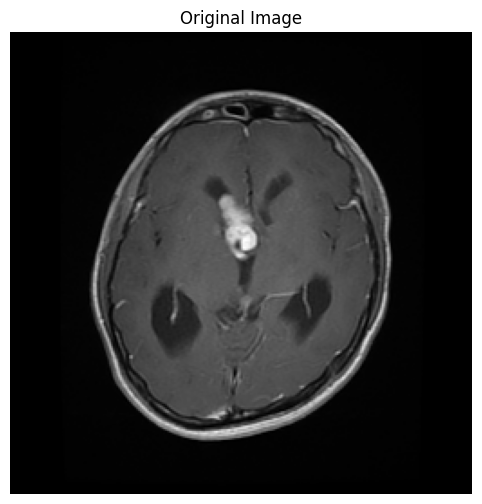

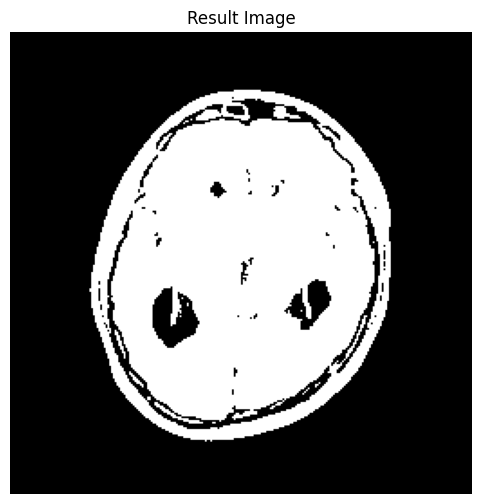

muryadi 11-img-00001-00001 (1).bmp
35.361328125


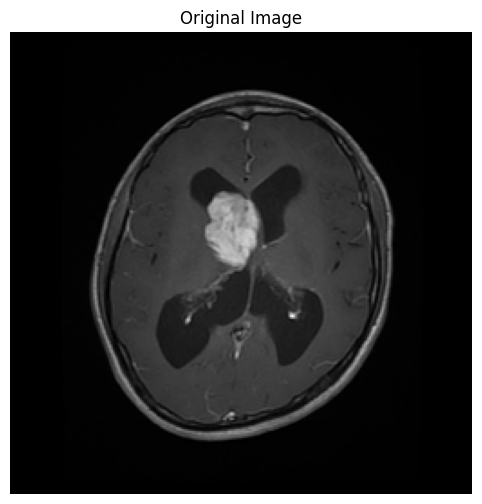

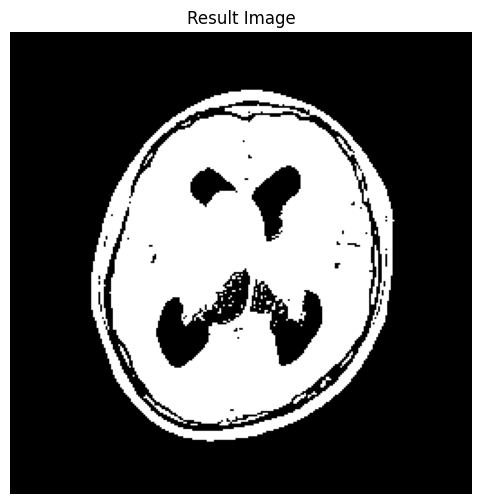

muryadi 9-img-00001-00001 (1).bmp
43.330078125


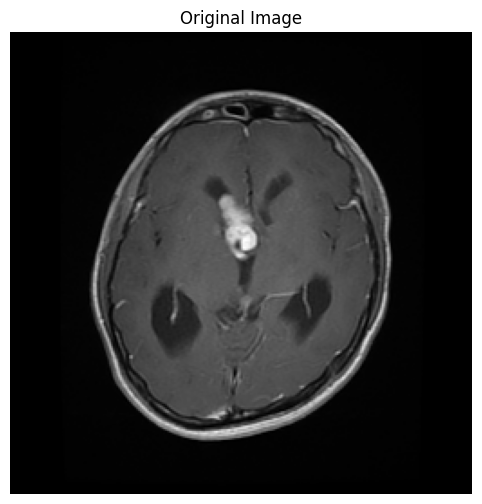

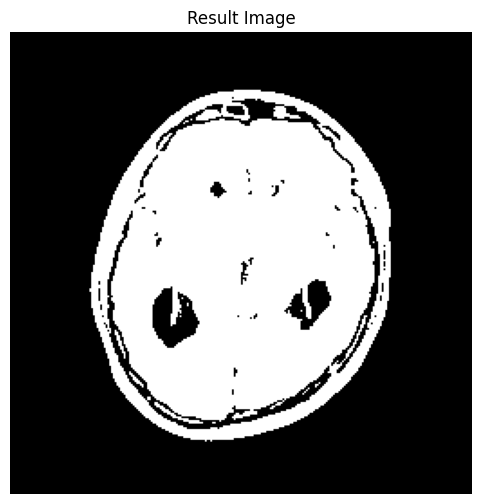

abdullah 7-img-00001-00001.bmp
43.330078125


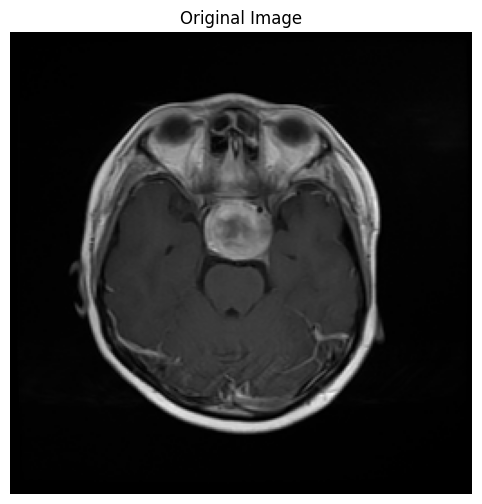

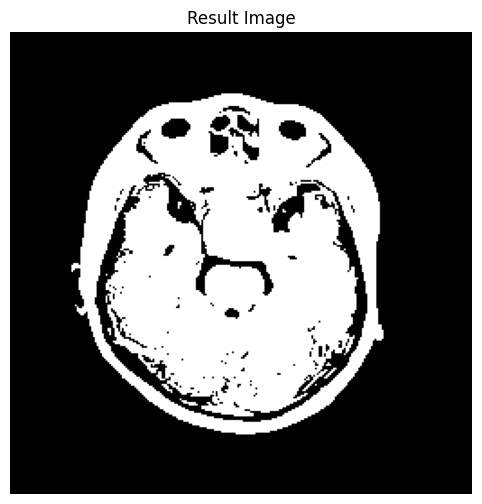

SAADAH 11-dicom-00001 (1).dcm
35.361328125


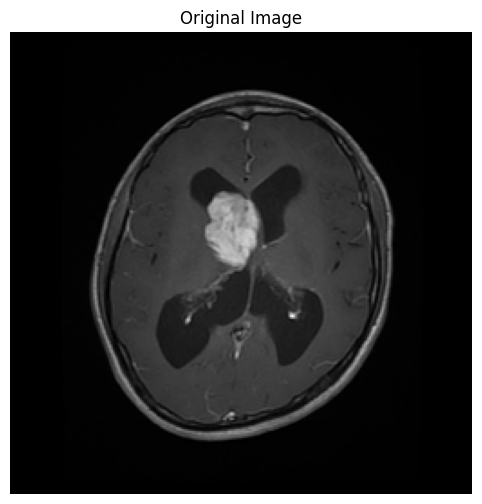

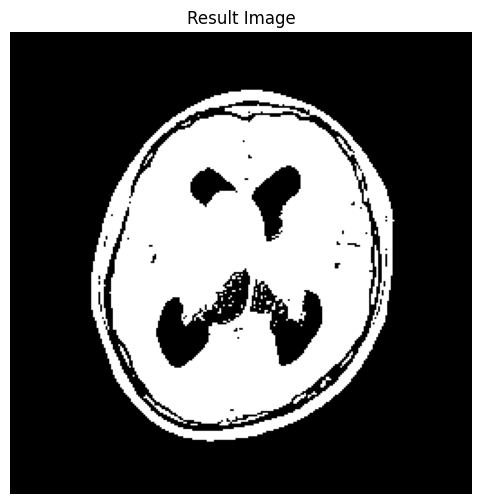

SAADAH 9-dicom-00001.dcm
125.205078125


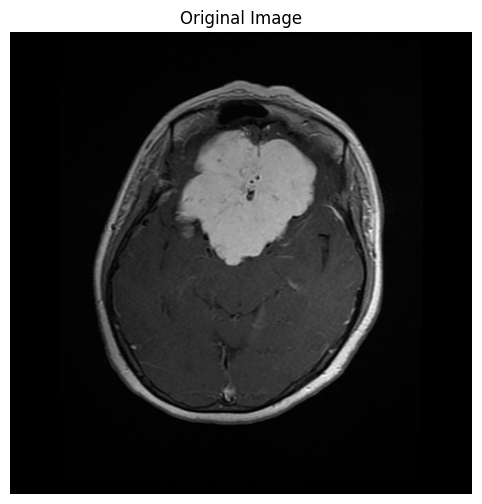

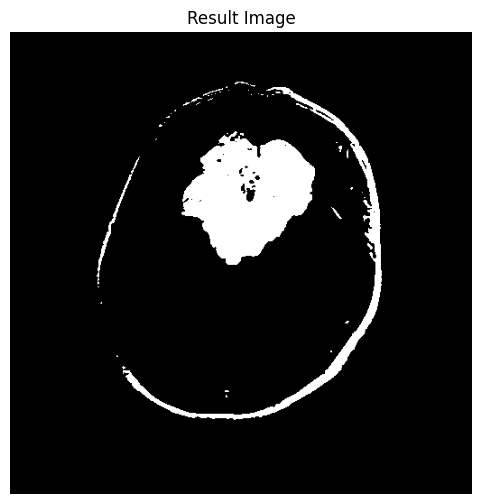

SAADAH 10-dicom-00001.dcm
126.201171875


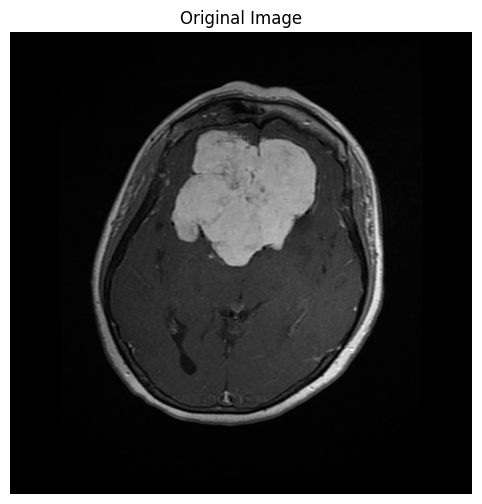

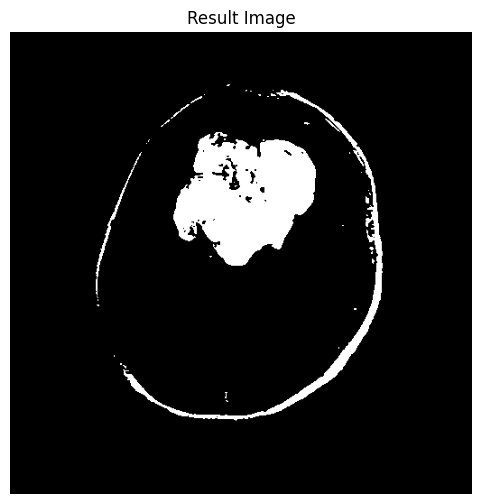

abdullah 9-img-00001-00001.bmp
40.341796875


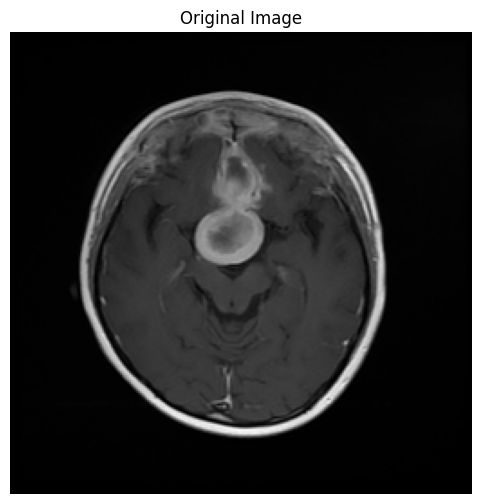

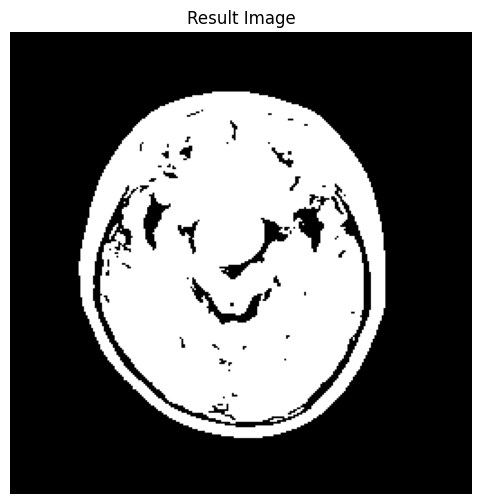

SAADAH 10-dicom-00001 (1).dcm
41.337890625


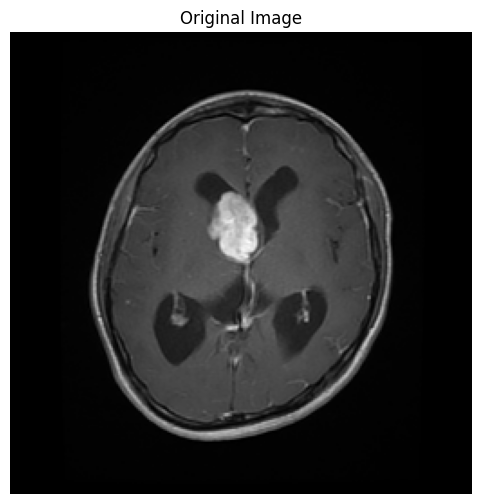

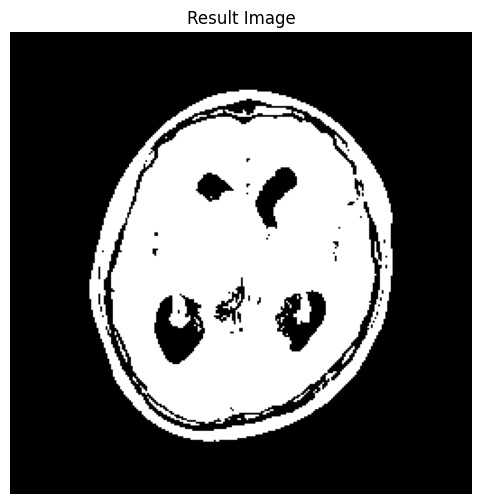

SAADAH 8-dicom-00001.dcm
112.255859375


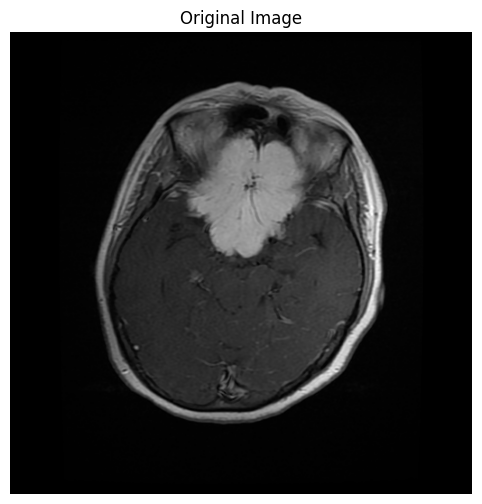

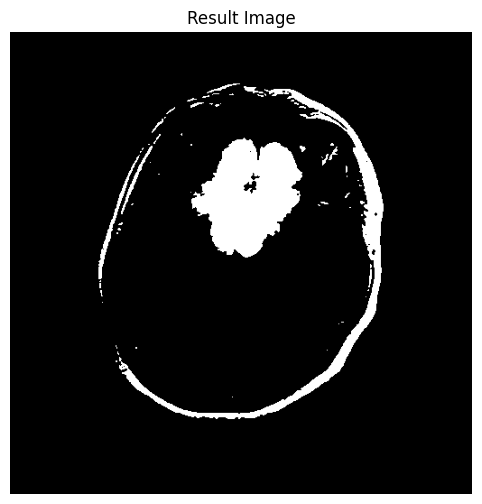

In [205]:
result_tumor_prediction = []
result_tumor_size = []
kwargs = {
    "offset": 0
}
for img_name, img in zip(list_img_names, list_read_img):
    print(img_name)
    result_image = image_segmentation_using_otsu_threshold(img, **kwargs)
    # is_tumor_detected = 1 if is_tumor_detected else 0
    # result_tumor_prediction.append(is_tumor_detected)
    # #Extract the tumor image from the original image
    # extracted_tumor_img = cv2.bitwise_and(img, img, mask=contours_inside_roi_mask)
    # result_tumor_size.append(calculate_roi_size(contours_inside_roi_mask))
    plot_img(img, title=f"Original Image")
    plot_img(result_image, title=f"Result Image")
    # plot_img(extracted_tumor_img, title="Result Extracted Tumor Image")

In [ ]:
import pandas as pd

df = pd.DataFrame(
    {"Filename": list_img_names, "Result Prediction": result_tumor_prediction, "Total area size (px)": result_tumor_size}
)
df

In [ ]:
df.to_csv("result_prediction.csv", index=False)

(33, 33)
(206, 224)


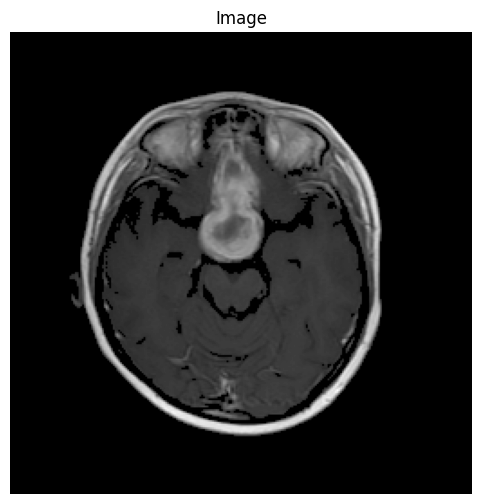

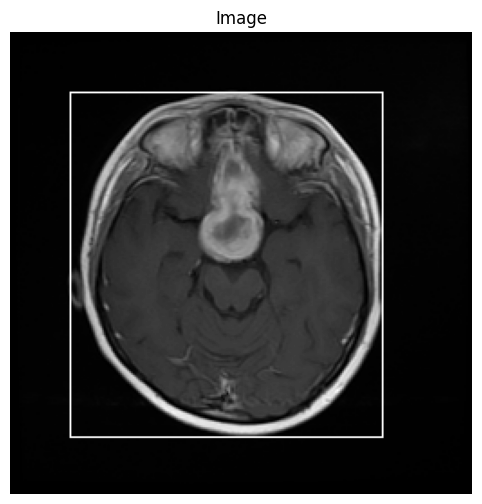

89.150390625


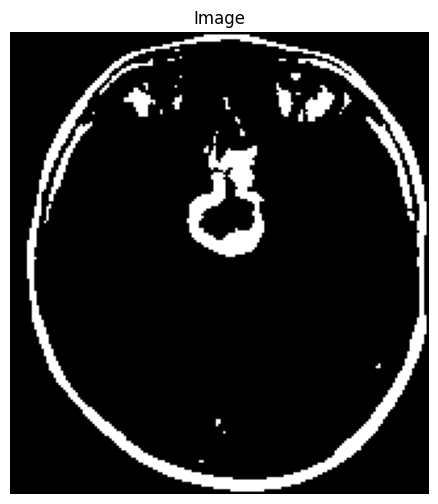

In [174]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the original image
original_image = cv2.imread("sample_input/abdullah 8-img-00001-00001.bmp", cv2.IMREAD_COLOR)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply Otsu's thresholding
_, otsu_thresholded = cv2.threshold(original_image, 0, 255, cv2.THRESH_TOZERO + cv2.THRESH_OTSU)

# Find contours in the thresholded image
contours, _ = cv2.findContours(otsu_thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bottom_right = (float('-inf'), float('-inf'))

# Iterate over the contours and find the top-left and bottom-right coordinates
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Update top-left coordinates
    top_left = (min(top_left[0], x), min(top_left[1], y))
    
    # Update bottom-right coordinates
    bottom_right = (max(bottom_right[0], x + w), max(bottom_right[1], y + h))


# Plot bounding boxes on the original image
image_with_boxes = original_image.copy()
print(top_left)
print(bottom_right)
# Draw bounding boxes
cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 255), 1)
# Convert BGR image to RGB for plotting with matplotlib
plot_img(otsu_thresholded)
plot_img(image_with_boxes)
# Crop the region defined by top-left and bottom-right coordinates
cropped_region = original_image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

# Apply Otsu's thresholding
otsu_thresholded_2 = image_segmentation_using_otsu_threshold(cropped_region, offset=40)
plot_img(otsu_thresholded_2)